<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/Project_Sophie/Shallow_water_Sophie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Shallow Water equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Shallow Water equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [141]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2024 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [142]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

# The Shallow Water equations take the form

$\dot u + (u\cdot \nabla)u + g \nabla w = 0,\quad \dot w + \nabla \cdot (w u) = 0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Shallow Water equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,w)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - g(\nabla w, v) + (\dot w + (\nabla \cdot (w u), q) + SD(u,w;v,q) = 0,$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,w;v,q)$ is a residual based stabilization term.


# **Method**

**Define domain and mesh**

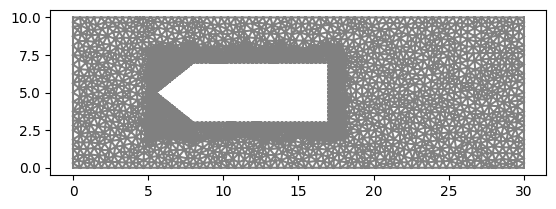

In [143]:
# Define rectangular domain
L = 30
H = 10


# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh
resolution = 45


# Define points for the boat hull (without bulb)
p1 = Point(17, 7)
p2 = Point(8, 7)
p3 = Point(5.5, 5)
p4 = Point(8, 3)
p5 = Point(17, 3)

# Define boat hull geometry
boat_hull = Polygon([p1, p2, p3, p4, p5])

# Define the domain and subtract the boat hull
domain = Rectangle(Point(0.0, 0.0), Point(L, H)) - boat_hull

# Define points for the boat hull (with the bulb)
#p1 = Point(17, 7)
#p2 = Point(8, 7)
#p3 = Point(6, 6)
#p4 = Point(5,6)
#p5 = Point(5,4)
#p6 = Point(6,4)
#p7 = Point(8, 3)
#p8 = Point(17, 3)

# Define boat hull geometry
#boat_hull = Polygon([p1, p2, p3, p4, p5, p6, p7, p8])

# Define the domain and subtract the boat hull
#domain = Rectangle(Point(0.0, 0.0), Point(L, H)) - boat_hull - Circle(Point(5,5),1)


# Generate mesh with boat geometry
mesh = generate_mesh(domain, resolution)


# Local mesh refinement (specified by a cell marker)
vertices = [Point(5, 2), Point(5, 8), Point(18, 3), Point(18, 8)]

# Create the polygon
refinement_rectangle = Rectangle(Point(5,2), Point(18, 8))

# Define function to mark cells inside the refinement polygon
def mark_cells_inside_polygon(mesh, polygon):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    cell_marker.set_all(False)
    for cell in cells(mesh):
        p = cell.midpoint()
        if  refinement_rectangle.inside(p):
            cell_marker[cell] = True
    return cell_marker

# Mark cells inside the refinement polygon
cell_marker = mark_cells_inside_polygon(mesh, refinement_rectangle)

# Refine mesh based on marked cells
mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [144]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
w = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [145]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

win = Expression('1.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
bcw0 = DirichletBC(Q, win, dbc_left)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcw = [bcw0]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [146]:
g = 1

**Define method parameters**

In [147]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
w0 = Function(Q)
w1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [148]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 2.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities and wave heights for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)
wm = 0.5*(w + w0)
wm1 = 0.5*(w1 + w0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx + g*inner(grad(wm1), v)*dx \
    + d1*inner(grad(um)*um1, grad(v)*um1)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fw = inner((w - w0)/dt, q)*dx + div(w*um1)*q*dx + d1*inner(inner(um1, grad(w)), inner(um1, grad(q)))*dx
aw = lhs(Fw)
Lw = rhs(Fw)

**Compute force on boundary**

In [149]:
# Define the direction of the force to be computed
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("(x[1] >= 3 && x[1] <= 6 && x[0] >= 3.5 && x[0] <= 10) ? phi_x : 0.0",
                             "(x[1] >= 3 && x[1] <= 6 && x[0] >= 3.5 && x[0] <= 10) ? phi_y : 0.0"),
                            phi_x=phi_x, phi_y=phi_y, element=V.ufl_element())

psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - g*inner(grad(wm1), psi)*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 6.5
normalization = -2.0/D

**Set plotting variables and open export files**

In [150]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_w = File("results-NS/w.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

Time t = 0.08291059244014164


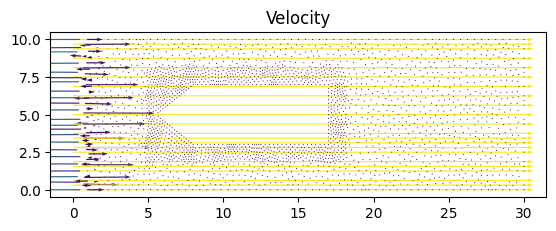

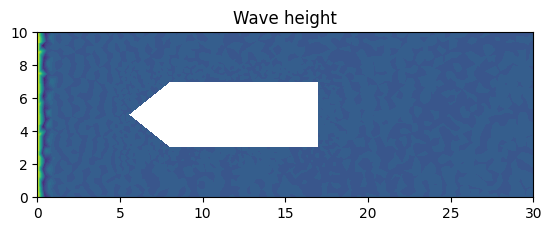

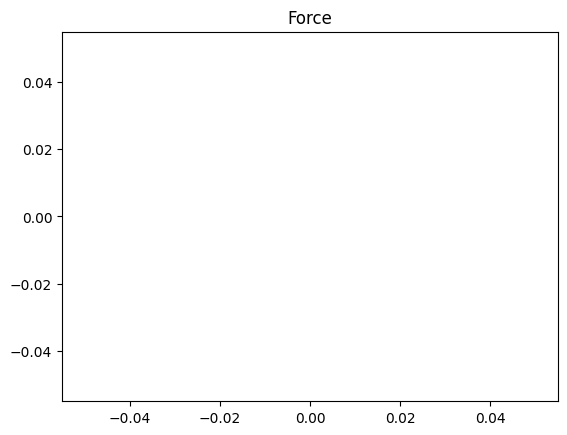

Time t = 3.067691920285238


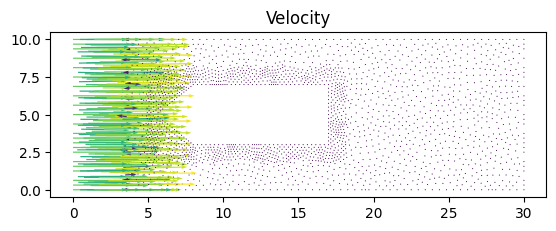

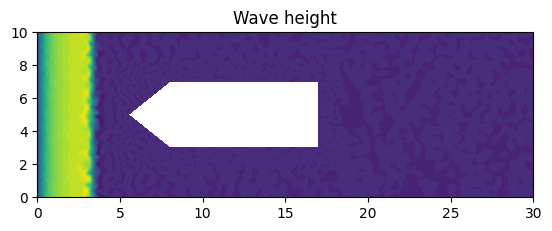

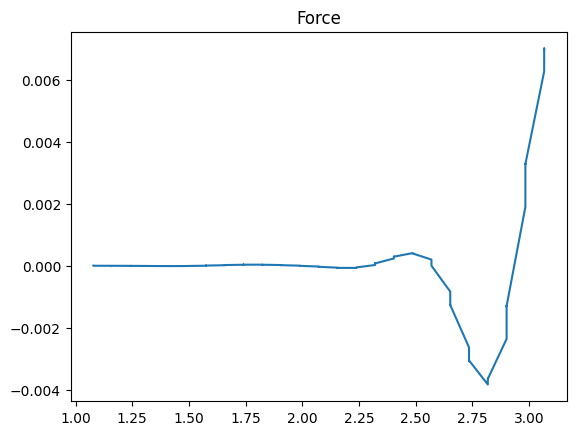

Time t = 6.05247324813033


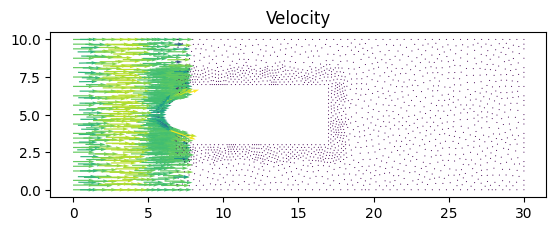

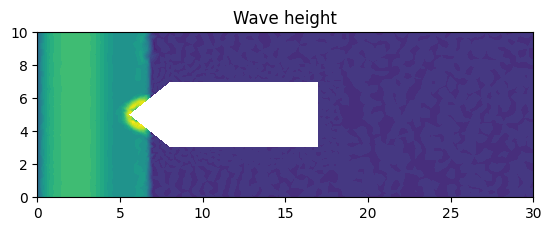

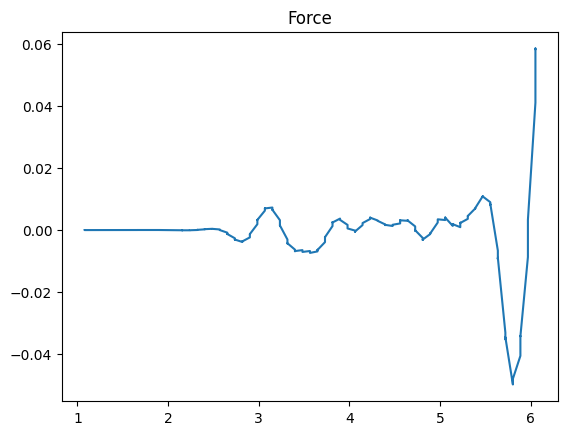

Time t = 9.037254575975421


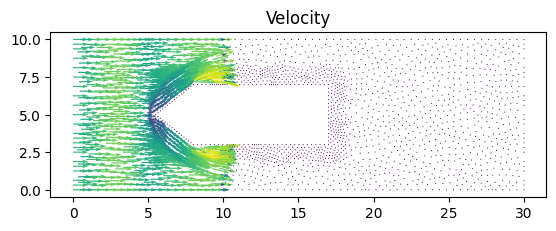

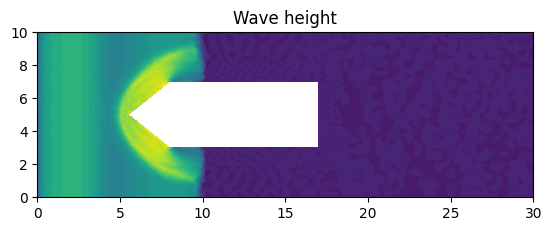

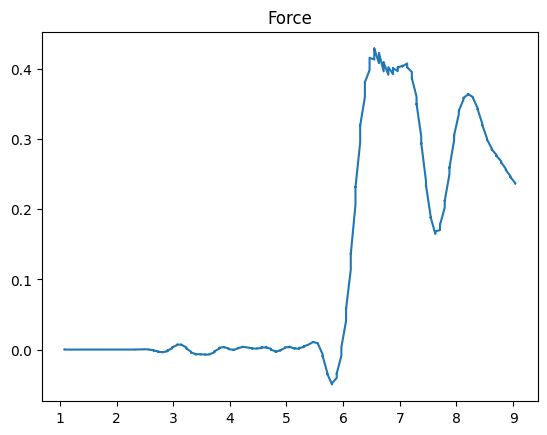

Time t = 12.022035903820512


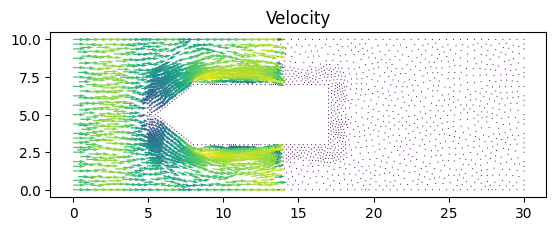

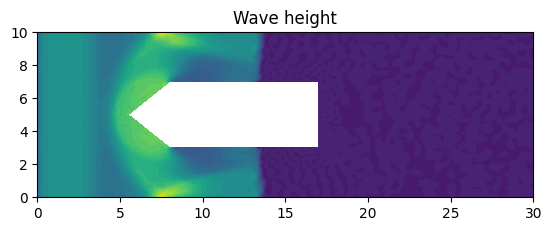

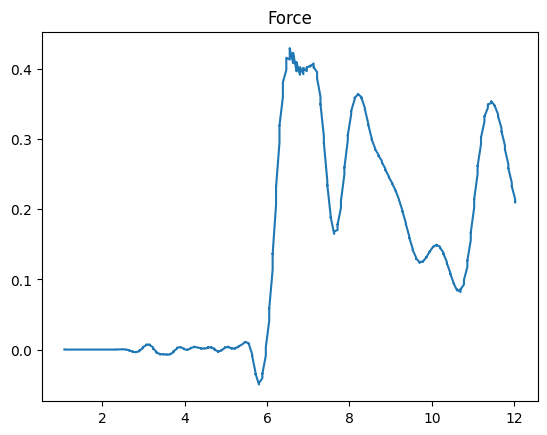

Time t = 15.006817231665604


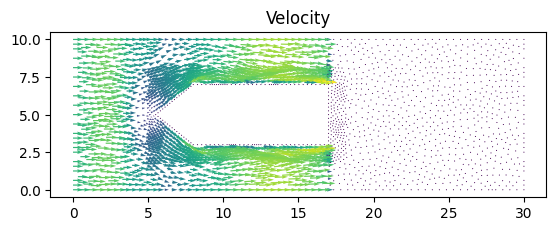

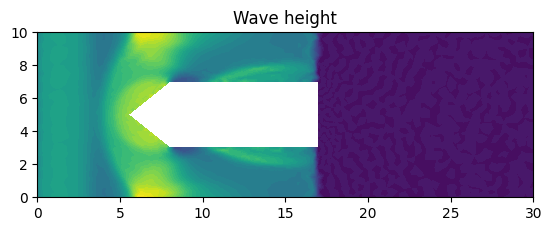

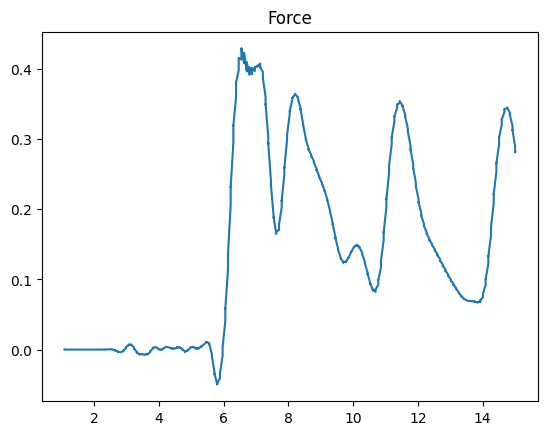

Time t = 18.07450915195088


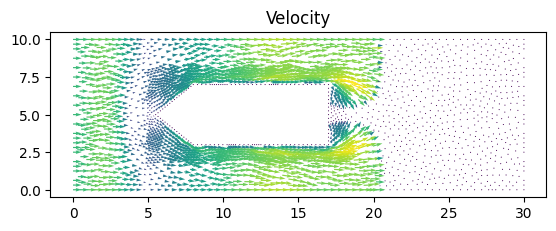

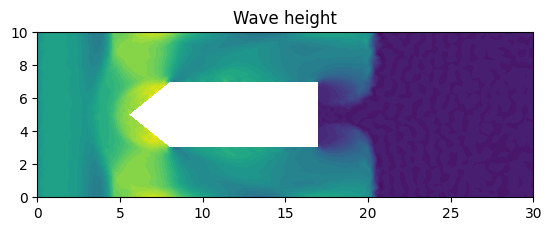

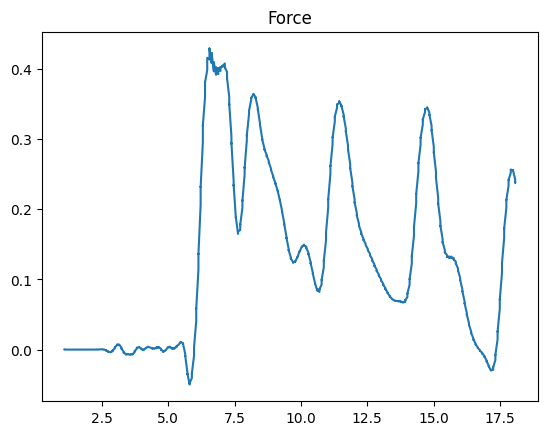

Time t = 21.059290479796037


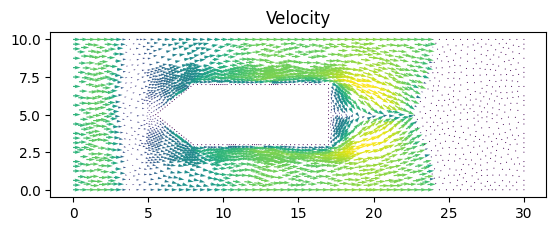

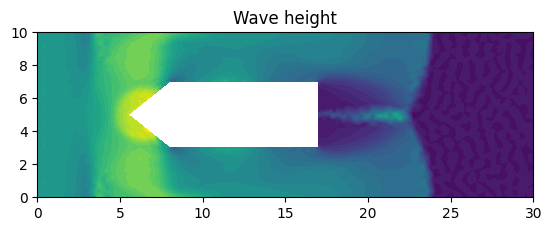

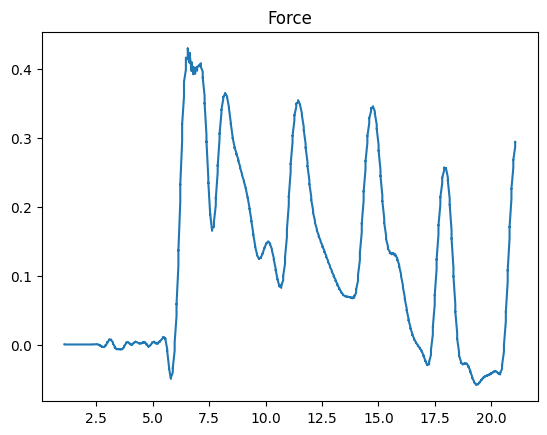

Time t = 24.044071807641192


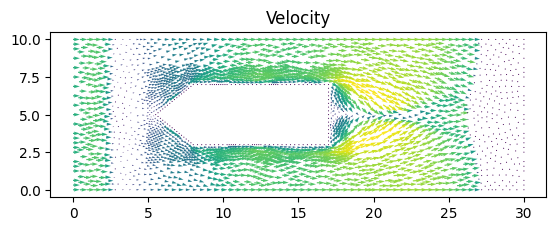

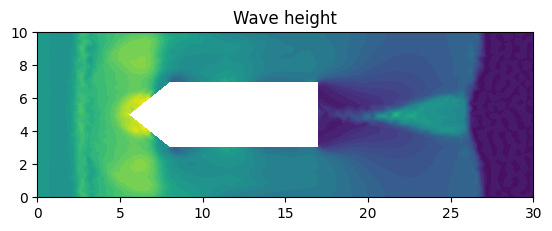

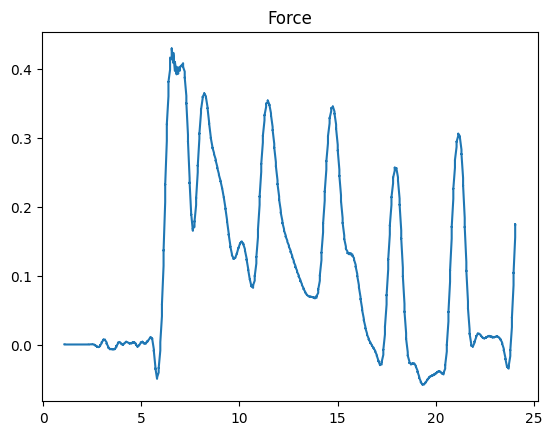

Time t = 27.028853135486347


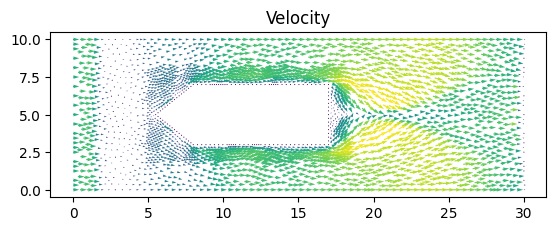

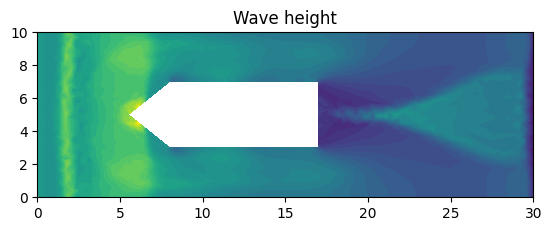

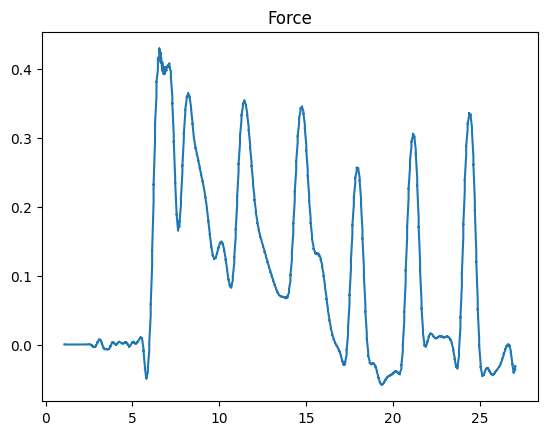

0.09777301362553971


In [151]:
!rm results-NS/*

# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    win.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Aw = assemble(aw)
        bw = assemble(Lw)

        # Compute pressure solution
        [bc.apply(Aw, bw) for bc in bcw]
        [bc.apply(w1.vector()) for bc in bcw]
        solve(Aw, w1.vector(), bw, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_w << w1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(w1, title="Wave height")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    w0.assign(w1)
    t += dt

FD = np.mean(force_array)
print(FD)

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Shallow Water equations in 2D. For a derivation of the equations, see e.g. https://users.oden.utexas.edu/~arbogast/cam397/dawson_v2.pdf